
Regression - Linear
  RMSE: 5.564
  MAE : 4.388
  R^2 : 0.291

Regression - RandomForest
  RMSE: 1.418
  MAE : 0.496
  R^2 : 0.954

Classification - Logistic
  Accuracy : 0.768
  Precision: 0.590
  Recall   : 0.908
  F1       : 0.715
  ROC AUC  : 0.831

Classification - RandomForest
  Accuracy : 0.992
  Precision: 1.000
  Recall   : 0.974
  F1       : 0.987
  ROC AUC  : 0.999


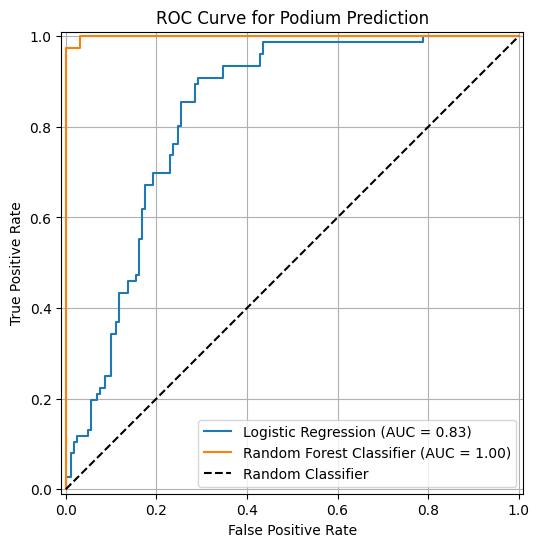

In [10]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# helper functions for RMSE and OneHotEncoder
def RMSE(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def build_ohe():
    # version-safe OneHotEncoder creation
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# load cleaned dataset
df = pd.read_csv(Path("Final_Project.csv"))

# select features available pre-race
num_candidates = [
    "GridPosition","NumStops","FirstPitLap","AvgStintLength",
    "Stint1Length","Stint2Length","Stint3Length",
    "AirTemp","TrackTemp","HumidityPct","WindSpeedKMH",
    "AvgPitStopTime","StopRelativePitLossSeconds","DriverAvgRelativePitLossSeconds"
]
cat_candidates = ["TrackType","StrategyType","OpeningCompound","LastCompound"]

num_features = [c for c in num_candidates if c in df.columns]
cat_features = [c for c in cat_candidates if c in df.columns]

# define prediction targets
target_reg = "RacePoints"   # continuous target for regression
target_clf = "IsPodium"     # binary target for classification

# subset datasets for each prediction type
df_reg = df.dropna(subset=[target_reg]) if target_reg in df.columns else None
df_clf = df.dropna(subset=[target_clf]) if target_clf in df.columns else None

# preprocessing pipelines
# numeric: impute median, scale
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

# categorical: impute mode, one-hot encode
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),("ohe", build_ohe())])

# combine numeric + categorical transformers
pre = ColumnTransformer([("num", num_pipe, num_features),("cat", cat_pipe, cat_features)], remainder="drop")

# Regression: RacePoints
if df_reg is not None and (len(num_features) + len(cat_features)) > 0:
    Xr = df_reg[num_features + cat_features]
    yr = df_reg[target_reg].astype(float)

    # split train/test
    Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.2, random_state=42)

    # model 1: Linear Regression
    reg_lin = Pipeline([("pre", pre), ("model", LinearRegression())])
    reg_lin.fit(Xr_tr, yr_tr)
    pred_lin = reg_lin.predict(Xr_te)

    # model 2: Random Forest Regressor
    reg_rf = Pipeline([("pre", pre), ("model", RandomForestRegressor(n_estimators=400, random_state=42))])
    reg_rf.fit(Xr_tr, yr_tr)
    pred_rf = reg_rf.predict(Xr_te)

    # evaluation metrics for regression
    def reg_report(name, y_true, y_pred):
        print(f"\n{name}")
        print(f"  RMSE: {RMSE(y_true, y_pred):.3f}")
        print(f"  MAE : {mean_absolute_error(y_true, y_pred):.3f}")
        print(f"  R^2 : {r2_score(y_true, y_pred):.3f}")

    reg_report("Regression - Linear", yr_te, pred_lin)
    reg_report("Regression - RandomForest", yr_te, pred_rf)
else:
    print("Regression skipped (missing target or features).")


# Classification: IsPodium
if df_clf is not None and (len(num_features) + len(cat_features)) > 0:
    Xc = df_clf[num_features + cat_features]
    yc = df_clf[target_clf].astype(int)

    # split train/test
    Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
        Xc, yc, test_size=0.2, random_state=42, stratify=yc if yc.nunique() == 2 else None
    )

    # model 1: Logistic Regression
    clf_log = Pipeline([("pre", pre), ("model", LogisticRegression(max_iter=200, class_weight="balanced"))])
    clf_log.fit(Xc_tr, yc_tr)
    proba_log = clf_log.predict_proba(Xc_te)[:, 1]
    pred_log = (proba_log >= 0.5).astype(int)

    # model 2: Random Forest Classifier
    clf_rf = Pipeline([("pre", pre), ("model", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))])
    clf_rf.fit(Xc_tr, yc_tr)
    proba_rf = clf_rf.predict_proba(Xc_te)[:, 1]
    pred_rf = (proba_rf >= 0.5).astype(int)

    # evaluation metrics for classification
    def clf_report(name, y_true, y_pred, y_proba):
        print(f"\n{name}")
        print(f"  Accuracy : {accuracy_score(y_true, y_pred):.3f}")
        print(f"  Precision: {precision_score(y_true, y_pred, zero_division=0):.3f}")
        print(f"  Recall   : {recall_score(y_true, y_pred, zero_division=0):.3f}")
        print(f"  F1       : {f1_score(y_true, y_pred, zero_division=0):.3f}")
        if len(np.unique(y_true)) == 2:
            print(f"  ROC AUC  : {roc_auc_score(y_true, y_proba):.3f}")

    clf_report("Classification - Logistic", yc_te, pred_log, proba_log)
    clf_report("Classification - RandomForest", yc_te, pred_rf, proba_rf)
else:
    print("Classification skipped (missing target or features).")

# plotting ROC Curves
if len(np.unique(yc_te)) == 2: # ensure it's a binary classification for ROC curve
    plt.figure(figsize=(8, 6))
    
    # plot ROC for Logistic Regression
    RocCurveDisplay.from_estimator(clf_log, Xc_te, yc_te, ax=plt.gca(), name="Logistic Regression")
    
    # plot ROC for Random Forest Classifier
    RocCurveDisplay.from_estimator(clf_rf, Xc_te, yc_te, ax=plt.gca(), name="Random Forest Classifier")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # diagonal random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Podium Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Classification skipped (missing target or features).")
